## Importing Libraries and Dataset

In [ ]:
!pip install bertopic
!pip install sentence-transformers
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import torch
import spacy
import pickle
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from google.colab import drive
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import normalize
from scipy.sparse import vstack

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/NLP_Project/data.csv'
csv.field_size_limit(sys.maxsize)
df = pd.read_csv(file_path, sep = '§')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-52-86709391>:4: ParserWarning:

Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.



In [ ]:
SEED = 1
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

#Embeddings for each level

In [ ]:
df_low = df.loc[df['Level'] == 'Low']
df_medium = df.loc[df['Level'] == 'Medium']
df_high = df.loc[df['Level'] == 'High']

In [ ]:
print(f'Number of Low level documents: {len(df_low)}')
print(f'Number of Medium level documents: {len(df_medium)}')
print(f'Number of High level documents: {len(df_high)}')

Number of Low level documents: 128664
Number of Medium level documents: 95046
Number of High level documents: 44064


In [ ]:
model = SentenceTransformer("BAAI/llm-embedder", device="cuda" if torch.cuda.is_available() else "cpu")
model.eval()

def generate_embeddings(texts, batch_size=64, normalize=True):
    with torch.no_grad():
        emb = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )
    if normalize:
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb

In [ ]:
texts_low = df_low['Cleaned_Body_n'].dropna().astype(str).tolist()
texts_medium = df_medium['Cleaned_Body_n'].dropna().astype(str).tolist()
texts_high = df_high['Cleaned_Body_n'].dropna().astype(str).tolist()

In [ ]:
embeddings_low = generate_embeddings(texts_low)
embeddings_medium = generate_embeddings(texts_medium)
embeddings_high = generate_embeddings(texts_high)

Batches:   0%|          | 0/1764 [00:00<?, ?it/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

Batches:   0%|          | 0/570 [00:00<?, ?it/s]

In [ ]:
# Check for identical embeddings
embeddings_test1 = generate_embeddings(texts_low[:1000])
embeddings_test2 = generate_embeddings(texts_low[:1000])

print("Identical Embeddings:", np.allclose(embeddings_test1, embeddings_test2, atol=1e-8))

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Identical Embeddings: True


#Grid search for the optimal number of topics

In [ ]:
with open("/content/drive/MyDrive/NLP_Project/vectorizer_low.pkl", "rb") as f:
    vectorizer_fixed = pickle.load(f)

In [ ]:
def evaluate_bertopic_cv(texts, embeddings, cluster_values=[8, 10, 12, 15], seed=1):
    results = []

    # Tokenize once outside the loop (simple whitespace split)
    tokenized_docs = [doc.lower().split() for doc in texts]
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

    for n_clusters in cluster_values:
        print(f"Evaluating model with {n_clusters} clusters...")

        # Set global seed
        set_global_seed(seed)

        # New PCA for each model
        pca = PCA(n_components=embeddings.shape[1], random_state=seed)

        # Set up vectorizer and clustering
        vectorizer = vectorizer_fixed
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)

        # Build BERTopic model
        topic_model = BERTopic(
            umap_model=pca,
            hdbscan_model=kmeans,
            vectorizer_model=vectorizer,
            calculate_probabilities=False,
            verbose=False
        )

        # Fit the model
        topics, _ = topic_model.fit_transform(texts, embeddings)

        # Extract top 10 words per topic
        topics_dict = topic_model.get_topics()
        topic_words = [
            [word for word, _ in topics_dict[i][:10]]
            for i in sorted(topics_dict)
        ]

        # Compute c_v coherence
        coherence_model = CoherenceModel(
            topics=topic_words,
            texts=tokenized_docs,
            dictionary=dictionary,
            coherence="c_v"
        )
        coherence = coherence_model.get_coherence()

        results.append({
            "n_clusters": n_clusters,
            "c_v": coherence,
            "n_topics_found": len(topic_words)
        })

    return pd.DataFrame(results).sort_values("c_v", ascending=False).reset_index(drop=True)

In [ ]:
set_global_seed(1)
results_low = evaluate_bertopic_cv(texts_low, embeddings_low)
print(results_low)

Evaluating model with 8 clusters...
Evaluating model with 10 clusters...
Evaluating model with 12 clusters...
Evaluating model with 15 clusters...
   n_clusters       c_v  n_topics_found
0          15  0.543372              15
1          12  0.515115              12
2          10  0.494386              10
3           8  0.442599               8


In [ ]:
set_global_seed(1)
results_medium = evaluate_bertopic_cv(texts_medium, embeddings_medium)
print(results_medium)

Evaluating model with 8 clusters...
Evaluating model with 10 clusters...
Evaluating model with 12 clusters...
Evaluating model with 15 clusters...
   n_clusters       c_v  n_topics_found
0           8  0.468620               8
1          15  0.428925              15
2          12  0.426544              12
3          10  0.412958              10


In [ ]:
set_global_seed(1)
results_high = evaluate_bertopic_cv(texts_high, embeddings_high)
print(results_high)

Evaluating model with 8 clusters...
Evaluating model with 10 clusters...
Evaluating model with 12 clusters...
Evaluating model with 15 clusters...
   n_clusters       c_v  n_topics_found
0          12  0.411262              12
1          15  0.403467              15
2          10  0.390258              10
3           8  0.380139               8


#BERTopic

In [ ]:
def build_bertopic_model(texts, embeddings, n_clusters=10, seed=1):
    set_global_seed(seed)

    # 1 Vectorizer
    vectorizer = vectorizer_fixed

    # 2 PCA
    pca = PCA(n_components=embeddings.shape[1], random_state=seed)

    # 3 KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)

    # 4 BERTopic
    topic_model = BERTopic(
        umap_model=pca,
        hdbscan_model=kmeans,
        vectorizer_model=vectorizer,
        calculate_probabilities=False,
        verbose=False
    )

    # 5 Fit
    topics, _ = topic_model.fit_transform(texts, embeddings)
    return topic_model, topics

In [ ]:
set_global_seed(1)
model_1, topics_1 = build_bertopic_model(texts_low, embeddings_low, n_clusters=10, seed=1)
set_global_seed(1)
model_2, topics_2 = build_bertopic_model(texts_low, embeddings_low, n_clusters=10, seed=1)

In [ ]:
np.array_equal(topics_1, topics_2)

True

###Low Level

In [ ]:
set_global_seed(1)
topic_model_low, topics_low = build_bertopic_model(texts_low, embeddings_low, n_clusters=15)
df_topics_low = topic_model_low.get_topic_info()

In [ ]:
# Keywords extraction
n_words = 10

# retrieve topics
for topic_id in topic_model_low.get_topics().keys():
    print(f"Topic {topic_id}:")
    words = topic_model_low.get_topic(topic_id)[:n_words]
    print(", ".join([word for word, _ in words]))
    print("-" * 80)

Topic 0:
thanks, questions, attached, contract, think, agreement, contact, credit, like, draft
--------------------------------------------------------------------------------
Topic 1:
thanks, email, send, sent, folder, attached, questions, ill, fax, hi
--------------------------------------------------------------------------------
Topic 2:
going, good, night, think, weekend, like, time, really, ill, hope
--------------------------------------------------------------------------------
Topic 3:
attached, changed, heres, website, viewing, ng, pl, latest, named, published
--------------------------------------------------------------------------------
Topic 4:
think, did, sorry, thought, didnt, want, like, going, really, good
--------------------------------------------------------------------------------
Topic 5:
deals, thanks, mw, changed, broker, kate, prebon, peak, entered, mike
--------------------------------------------------------------------------------
Topic 6:
going, ill, tomo

In [ ]:
# Labels for each topic
topic_labels = {
    0:  "Contract Drafting & Credit Agreements",
    1:  "Email Filing & Internal Correspondence",
    2:  "Personal Availability & Informal Updates",
    3:  "Document Revisions & Web Uploads",
    4:  "Decision Rationales & Uncertainty",
    5:  "Energy Brokerage Deals & Transactions",
    6:  "Absences & Schedule Adjustments",
    7:  "Energy Market & State Regulation (California Crisis)",
    8:  "ISDA Contracts & Legal Execution",
    9:  "Status Confirmations & Internal Feedback",
    10: "Enron Financials, Stock Market & Investor Focus",
    11: "System Failures & Load Forecasting Logs",
    12: "Meeting Coordination & Internal Planning",
    13: "Energy Variance Reporting",
    14: "Transmission Reports & Operational Anomalies"
}

# Compute Cosine Similarity within each topic
def compute_cosine_coherence(topic_model):
    all_topic_ids = sorted(topic_model.get_topics().keys())
    ctfidf = topic_model.c_tf_idf_
    topic_words_matrix = ctfidf.toarray()

    coherence_scores = {}
    for topic_id in all_topic_ids:
        words = topic_model.get_topic(topic_id)
        word_indices = [topic_model.vectorizer_model.vocabulary_.get(word[0])
                        for word in words if word[0] in topic_model.vectorizer_model.vocabulary_]

        if len(word_indices) < 2:
            coherence_scores[topic_id] = 0.0
            continue

        word_vectors = topic_words_matrix[:, word_indices].T
        similarity_matrix = cosine_similarity(word_vectors)
        upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
        avg_similarity = np.mean(upper_triangle) if upper_triangle.size > 0 else 0.0
        coherence_scores[topic_id] = avg_similarity

    return coherence_scores

# Compute coherence and assign lables
coherence_scores = compute_cosine_coherence(topic_model_low)
df_topics_low["Coherence"] = df_topics_low.Topic.apply(lambda x: coherence_scores.get(x, 0.0))
df_topics_low["Label"] = df_topics_low["Topic"].map(topic_labels)

df_final = df_topics_low.sort_values("Coherence", ascending=False).reset_index(drop=True)
pd.set_option("display.max_colwidth", None)
display(df_final[["Topic", "Label", "Count", "Coherence"]])

,Topic,Label,Count,Coherence
0,14,Transmission Reports & Operational Anomalies,1445,0.999389
1,9,Status Confirmations & Internal Feedback,5730,0.948218
2,13,Energy Variance Reporting,3737,0.928081
3,8,ISDA Contracts & Legal Execution,6751,0.890890
4,3,Document Revisions & Web Uploads,9366,0.864306
5,11,System Failures & Load Forecasting Logs,5401,0.859889
6,10,"Enron Financials, Stock Market & Investor Focus",5642,0.826342
7,5,Energy Brokerage Deals & Transactions,7936,0.792804
8,2,Personal Availability & Informal Updates,11920,0.766948
9,7,Energy Market & State Regulation (California Crisis),6953,0.754553


In [ ]:
# Plotting topic evolution over time
texts_low = df_low["Cleaned_Body_n"].dropna().astype(str).tolist()
timestamps_low = df_low.loc[df_low["Cleaned_Body_n"].notna(), "Date"]
timestamps_low = pd.to_datetime(timestamps_low, errors='coerce').tolist()

In [ ]:
# Compute topic evolution over time
topics_over_time_low = topic_model_low.topics_over_time(
    docs=texts_low,
    topics=topics_low,
    timestamps=timestamps_low,
    nr_bins=80
)

# Use labels (già definite nel dizionario topic_labels)
labels_ordered = [topic_labels[i] for i in sorted(topic_labels.keys())]
topic_model_low.set_topic_labels(labels_ordered)

# Plot only the most relevant topics
selected_topics = [13, 8, 11, 10, 5, 7]
topics_over_time_filtered = topics_over_time_low[topics_over_time_low.Topic.isin(selected_topics)]

topic_model_low.visualize_topics_over_time(
    topics_over_time_filtered,
    custom_labels=True
).show()

###Medium Level

In [ ]:
set_global_seed(1)
topic_model_medium, topics_medium = build_bertopic_model(texts_medium, embeddings_medium, n_clusters=8)
df_topics_medium = topic_model_medium.get_topic_info()

In [ ]:
# Keywords extraction
n_words = 10

# retrieve topics
for topic_id in topic_model_medium.get_topics().keys():
    print(f"Topic {topic_id}:")
    words = topic_model_medium.get_topic(topic_id)[:n_words]
    print(", ".join([word for word, _ in words]))
    print("-" * 80)

Topic 0:
carol, game, told, early, leaving, meetings, hes, doesnt, suzanne, believe
--------------------------------------------------------------------------------
Topic 1:
description, chairperson, folder, stacey, entry, detailed, carol, white, standard, clair
--------------------------------------------------------------------------------
Topic 2:
credit, legal, agreements, carol, guaranty, section, transaction, respect, termination, amendment
--------------------------------------------------------------------------------
Topic 3:
yea, game, bad, yep, funny, believe, remember, bet, gets, golf
--------------------------------------------------------------------------------
Topic 4:
power, market, utilities, electricity, rate, davis, edison, utility, commission, costs
--------------------------------------------------------------------------------
Topic 5:
enron, corp, enrons, transactions, america, north, total, daily, counterparties, average
----------------------------------------

In [ ]:
# Labels for each topic
topic_labels = {
    0: "Executive Departures & Internal Uncertainty",
    1: "Committee Records & Administrative Filing",
    2: "Legal Agreements & Credit Guaranty Structures",
    3: "Casual Chats & Informal Humor Threads",
    4: "Electricity Market & California Utility Crisis",
    5: "Enron Transactions & Counterparty Exposure",
    6: "Employee Celebrations & Personal Messages",
    7: "Unstructured Replies & Noisy Fragments"
}

# Compute coherence and assign lables
coherence_scores = compute_cosine_coherence(topic_model_low)
df_topics_medium["Coherence"] = df_topics_medium.Topic.apply(lambda x: coherence_scores.get(x, 0.0))
df_topics_medium["Label"] = df_topics_medium["Topic"].map(topic_labels)

df_final = df_topics_medium.sort_values("Coherence", ascending=False).reset_index(drop=True)
pd.set_option("display.max_colwidth", None)
display(df_final[["Topic", "Label", "Count", "Coherence"]])

,Topic,Label,Count,Coherence
0,3,Casual Chats & Informal Humor Threads,11846,0.438238
1,5,Enron Transactions & Counterparty Exposure,5614,0.436059
2,7,Unstructured Replies & Noisy Fragments,2157,0.243105
3,0,Executive Departures & Internal Uncertainty,18795,0.230186
4,2,Legal Agreements & Credit Guaranty Structures,13076,0.000000
5,1,Committee Records & Administrative Filing,13928,0.000000
6,4,Electricity Market & California Utility Crisis,10882,0.000000
7,6,Employee Celebrations & Personal Messages,4715,0.000000


In [ ]:
# Plotting topic evolution over time
texts_medium = df_medium["Cleaned_Body_n"].dropna().astype(str).tolist()
timestamps_medium = df_medium.loc[df_medium["Cleaned_Body_n"].notna(), "Date"]
timestamps_medium = pd.to_datetime(timestamps_medium, errors='coerce').tolist()

In [ ]:
# Compute topic evolution over time
topics_over_time_medium = topic_model_medium.topics_over_time(
    docs=texts_medium,
    topics=topics_medium,
    timestamps=timestamps_medium,
    nr_bins=80
)

# Use lables
labels_ordered = [topic_labels[i] for i in sorted(topic_labels.keys())]
topic_model_medium.set_topic_labels(labels_ordered)

# Plot only the most relevant topics
selected_topics = [5, 2, 1, 4]
topics_over_time_filtered = topics_over_time_medium[topics_over_time_medium.Topic.isin(selected_topics)]

topic_model_medium.visualize_topics_over_time(
    topics_over_time_filtered,
    custom_labels=True
).show()

###High Level

In [ ]:
set_global_seed(1)
topic_model_high, topics_high = build_bertopic_model(texts_high, embeddings_high, n_clusters=12)
df_topics_high = topic_model_high.get_topic_info()

In [ ]:
# Keywords extraction
n_words = 10

# retrieve topics
for topic_id in topic_model_high.get_topics().keys():
    print(f"Topic {topic_id}:")
    words = topic_model_high.get_topic(topic_id)[:n_words]
    print(", ".join([word for word, _ in words]))
    print("-" * 80)

Topic 0:
shall, com, group, list, pm, interested, interview, got, regarding, contact
--------------------------------------------------------------------------------
Topic 1:
shall, monday, thursday, dinner, night, lunch, going, saturday, wednesday, pm
--------------------------------------------------------------------------------
Topic 2:
gas, power, market, prices, trading, business, value, million, issues, going
--------------------------------------------------------------------------------
Topic 3:
task, com, stinson, going, picture, guess, sie, use, whats, derrick
--------------------------------------------------------------------------------
Topic 4:
blackberry, wireless, handheld, phone, address, list, tx, com, request, contact
--------------------------------------------------------------------------------
Topic 5:
shirley, shall, interview, stinson, vasant, register, invite, krishna, anita, julie
------------------------------------------------------------------------------

In [ ]:
# Labels for each topic
topic_labels = {
    0:  "Executive Interview Coordination & Outreach",
    1:  "Unstructured Scheduling Amid Executive Chaos",
    2:  "Energy Market Instability & Gas Price Pressure",
    3:  "Internal Distractions & Managerial Informalities",
    4:  "Mobile Device Support Under Operational Stress",
    5:  "Last-Minute Invitations & Scrambled Executive Panels",
    6:  "Global Operations & Trading Exposure in Crisis Zones",
    7:  "Document Routing & Pressure on Business Units",
    8:  "Overcompensation & Performative Praise in Turmoil",
    9:  "Regional Power Structures & Enron’s Executive Web",
    10: "Task Overload, Firefighting & Reactive Management",
    11: "High-Volume Print Requests & Communication Bottlenecks"
}

# Compute coherence and assign lables
coherence_scores = compute_cosine_coherence(topic_model_low)
df_topics_high["Coherence"] = df_topics_high.Topic.apply(lambda x: coherence_scores.get(x, 0.0))
df_topics_high["Label"] = df_topics_high["Topic"].map(topic_labels)

df_final = df_topics_high.sort_values("Coherence", ascending=False).reset_index(drop=True)
pd.set_option("display.max_colwidth", None)
display(df_final[["Topic", "Label", "Count", "Coherence"]])

,Topic,Label,Count,Coherence
0,1,Unstructured Scheduling Amid Executive Chaos,4338,0.459706
1,5,Last-Minute Invitations & Scrambled Executive Panels,3277,0.448006
2,3,Internal Distractions & Managerial Informalities,3810,0.435400
3,7,Document Routing & Pressure on Business Units,2898,0.406528
4,8,Overcompensation & Performative Praise in Turmoil,2024,0.400942
5,0,Executive Interview Coordination & Outreach,5357,0.396005
6,10,"Task Overload, Firefighting & Reactive Management",1373,0.287918
7,11,High-Volume Print Requests & Communication Bottlenecks,567,0.241786
8,6,Global Operations & Trading Exposure in Crisis Zones,3121,0.122366
9,4,Mobile Device Support Under Operational Stress,3484,0.039498


In [ ]:
# Plotting topic evolution over time
texts_high = df_high["Cleaned_Body_n"].dropna().astype(str).tolist()
timestamps_high = df_high.loc[df_high["Cleaned_Body_n"].notna(), "Date"]
timestamps_high = pd.to_datetime(timestamps_high, errors='coerce').tolist()

In [ ]:
# Compute topic evolution over time
topics_over_time_high = topic_model_high.topics_over_time(
    docs=texts_high,
    topics=topics_high,
    timestamps=timestamps_high,
    nr_bins=80
)

# Use lables
labels_ordered = [topic_labels[i] for i in sorted(topic_labels.keys())]
topic_model_high.set_topic_labels(labels_ordered)

# Plot only the most relevant topics
selected_topics = [2, 6, 10, 9, 0]
topics_over_time_filtered = topics_over_time_high[topics_over_time_high.Topic.isin(selected_topics)]

topic_model_high.visualize_topics_over_time(
    topics_over_time_filtered,
    custom_labels=True
).show()

#Overlapping among topics

In [ ]:
def compare_topics(model_a, model_b, top_n=10, cos_threshold=0.7, jacc_threshold=0.5):
    vocab_a = model_a.vectorizer_model.get_feature_names_out()
    vocab_b = model_b.vectorizer_model.get_feature_names_out()

    common_vocab = list(set(vocab_a) & set(vocab_b))

    idx_map_a = {word: i for i, word in enumerate(vocab_a)}
    idx_map_b = {word: i for i, word in enumerate(vocab_b)}

    common_idx_a = [idx_map_a[word] for word in common_vocab]
    common_idx_b = [idx_map_b[word] for word in common_vocab]

    ctfidf_a_common = model_a.c_tf_idf_[:, common_idx_a]
    ctfidf_b_common = model_b.c_tf_idf_[:, common_idx_b]

    topics_a = [t for t in model_a.get_topic_info().Topic.unique() if t >= 0]
    topics_b = [t for t in model_b.get_topic_info().Topic.unique() if t >= 0]

    cos_sim = cosine_similarity(ctfidf_a_common, ctfidf_b_common)

    overlaps = []

    for i, a_id in enumerate(topics_a):
        for j, b_id in enumerate(topics_b):
            cs = cos_sim[i, j]
            if cs < cos_threshold:
                continue

            top_a = set(get_top_words(model_a, a_id, top_n))
            top_b = set(get_top_words(model_b, b_id, top_n))
            jacc = len(top_a & top_b) / len(top_a | top_b) if top_a | top_b else 0

            if jacc >= jacc_threshold:
                overlaps.append((a_id, b_id, cs, jacc))

    return overlaps

overlap_low_med = compare_topics(topic_model_low, topic_model_medium)
print("Overlap Low vs Medium (c-TF-IDF):", overlap_low_med)

Overlap Low vs Medium (c-TF-IDF): []


In [ ]:
overlap_low_med = compare_topics(topic_model_low, topic_model_medium,
                                 cos_threshold=0.5, jacc_threshold=0)
overlap_med_high = compare_topics(topic_model_medium, topic_model_high,
                                  cos_threshold=0.5, jacc_threshold=0)

In [ ]:
print("Overlap Low vs Medium:", overlap_low_med)

Overlap Low vs Medium: []


In [ ]:
print("Overlap Medium vs High:", overlap_med_high)

Overlap Medium vs High: []


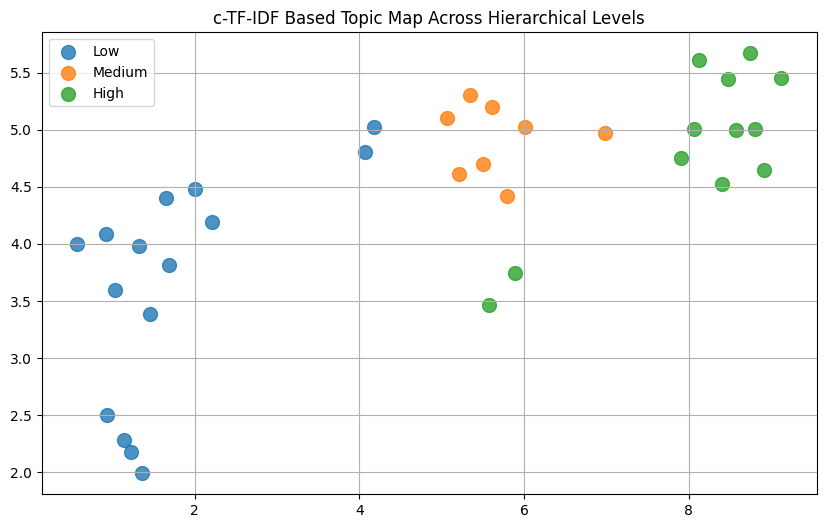

In [ ]:
vocab_low = set(topic_model_low.vectorizer_model.get_feature_names_out())
vocab_med = set(topic_model_medium.vectorizer_model.get_feature_names_out())
vocab_high = set(topic_model_high.vectorizer_model.get_feature_names_out())

common_vocab = sorted(list(vocab_low & vocab_med & vocab_high))

# 2. c-TF-IDF
def get_aligned_ctfidf(model, common_vocab):
    vocab = model.vectorizer_model.get_feature_names_out()
    idx_map = {word: i for i, word in enumerate(vocab)}
    common_idx = [idx_map[word] for word in common_vocab if word in idx_map]
    return model.c_tf_idf_[:, common_idx]

ctfidf_low = get_aligned_ctfidf(topic_model_low, common_vocab)
ctfidf_med = get_aligned_ctfidf(topic_model_medium, common_vocab)
ctfidf_high = get_aligned_ctfidf(topic_model_high, common_vocab)

# 3. Merge
all_ctfidf = vstack([ctfidf_low, ctfidf_med, ctfidf_high])
if hasattr(all_ctfidf, 'toarray'):
    all_ctfidf = all_ctfidf.toarray()

# 4. Metadata
labels = (
    ["Low"] * ctfidf_low.shape[0] +
    ["Medium"] * ctfidf_med.shape[0] +
    ["High"] * ctfidf_high.shape[0]
)
topic_ids = list(range(ctfidf_low.shape[0])) + \
            list(range(ctfidf_med.shape[0])) + \
            list(range(ctfidf_high.shape[0]))

df_meta = pd.DataFrame({"Level": labels, "TopicID": topic_ids})

# 5. UMAP
reducer = umap.UMAP(n_neighbors=5, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(normalize(all_ctfidf))

# 6. Plot
plt.figure(figsize=(10, 6))
for level in ["Low", "Medium", "High"]:
    mask = df_meta["Level"] == level
    plt.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        label=level,
        alpha=0.8,
        s=100
    )

plt.title("c-TF-IDF Based Topic Map Across Hierarchical Levels")
plt.legend()
plt.grid(True)
plt.show()

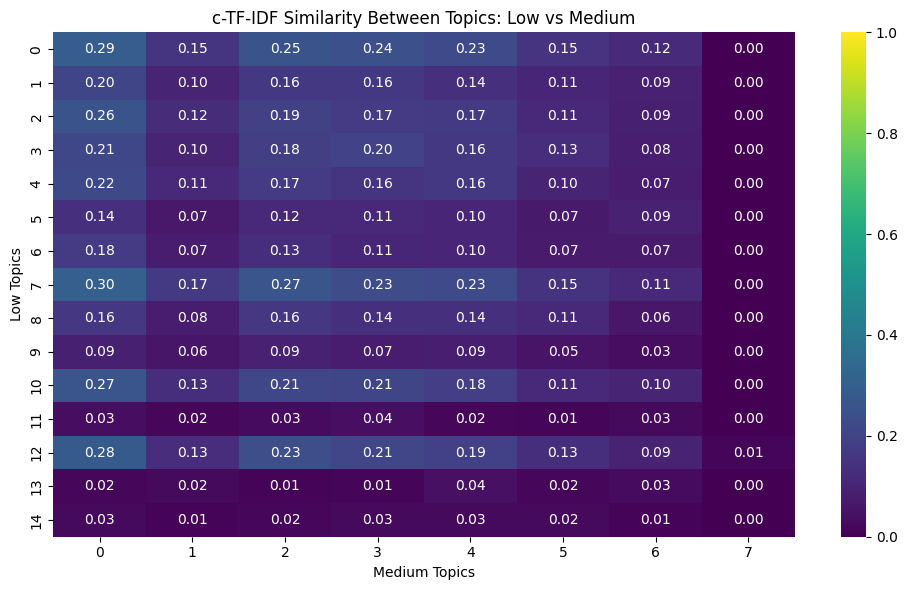

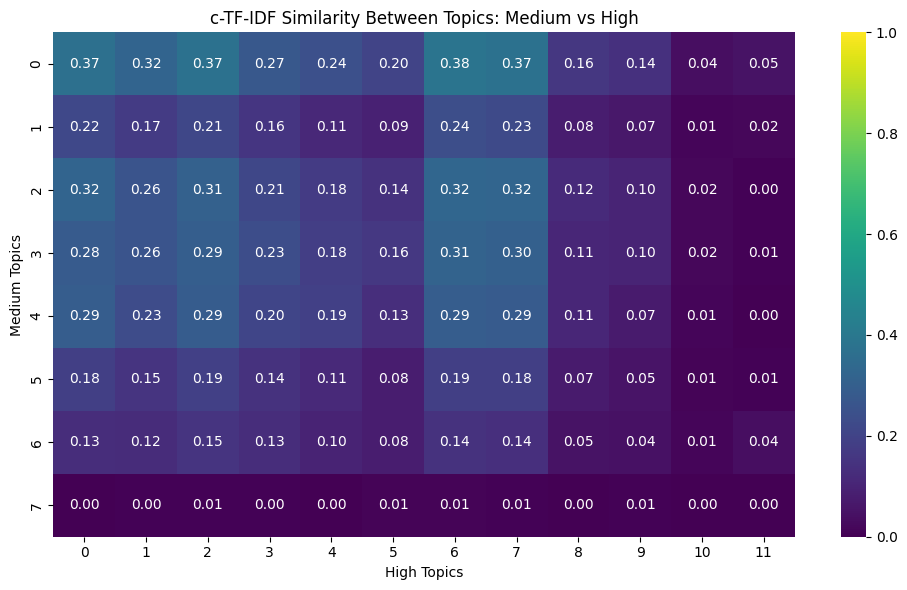

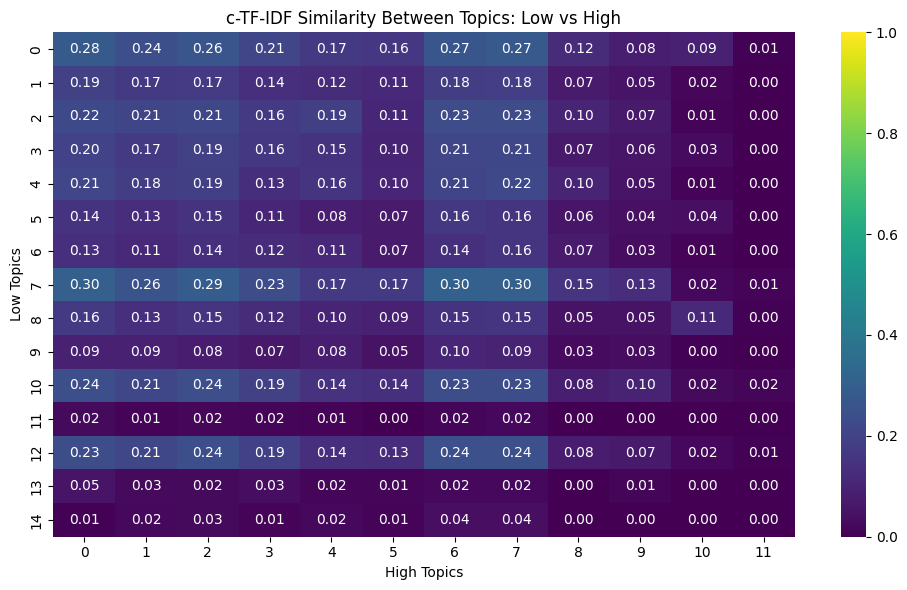

In [ ]:
def plot_similarity_heatmap(model_a, model_b, label_a="Model A", label_b="Model B"):
    vocab_a = model_a.vectorizer_model.get_feature_names_out()
    vocab_b = model_b.vectorizer_model.get_feature_names_out()

    common_vocab = list(set(vocab_a) & set(vocab_b))

    idx_map_a = {word: i for i, word in enumerate(vocab_a)}
    idx_map_b = {word: i for i, word in enumerate(vocab_b)}

    common_idx_a = [idx_map_a[word] for word in common_vocab]
    common_idx_b = [idx_map_b[word] for word in common_vocab]

    ctfidf_a_common = model_a.c_tf_idf_[:, common_idx_a]
    ctfidf_b_common = model_b.c_tf_idf_[:, common_idx_b]

    sim_matrix = cosine_similarity(ctfidf_a_common, ctfidf_b_common)

    ids_a = [i for i in model_a.get_topic_info().Topic.unique() if i >= 0]
    ids_b = [i for i in model_b.get_topic_info().Topic.unique() if i >= 0]

    plt.figure(figsize=(10, 6))
    sns.heatmap(sim_matrix,
                xticklabels=ids_b,
                yticklabels=ids_a,
                cmap="viridis",
                annot=True,
                fmt=".2f",
                vmin=0,
                vmax=1)

    plt.xlabel(f"{label_b} Topics")
    plt.ylabel(f"{label_a} Topics")
    plt.title(f"c-TF-IDF Similarity Between Topics: {label_a} vs {label_b}")
    plt.tight_layout()
    plt.show()

# Heatmap
plot_similarity_heatmap(topic_model_low, topic_model_medium, "Low", "Medium")
plot_similarity_heatmap(topic_model_medium, topic_model_high, "Medium", "High")
plot_similarity_heatmap(topic_model_low, topic_model_high, "Low", "High")